# Mentoría 'de cómo clasificar en géneros a las canciones'
## Práctico II : Análisis de features de audio

Algunas aclaraciones:
- En 2) todos los pasos deberían poder hacerse en una línea, aunque si se complican y necesitan hacerlo en más no hay problema
- En 3) les dejé un buen spoiler para que lo completen
- Todas los conceptos y librerias que vamos a usar están documentados en el notebook
- Esta vez vamos a ser más rígidos con los plazos, la entrega es el 05/08, la única instancia previa de corrección son las entregas ANTES de la fecha mencionada, caso contrario es la nota final.

### Librerías

!pip3 install spotipy
!pip3 install pandas
!pip3 install spacy
!pip3 install pymusixmatch
!pip3 install nltk
!pip3 install wordcloud
!pip3 install matplotlib
!pip3 install seaborn

# Agregar las librerías extra que se utilicen en esta celda y la siguiente

### Dependencias y acceso al API

In [191]:
import pandas as pd
import numpy as np
import spotipy
import spacy
from spotipy.oauth2 import SpotifyClientCredentials
import requests
import json
import seaborn as sns
import tqdm
from collections import Counter
from nltk import ngrams, bigrams
import nltk
import itertools
from wordcloud import WordCloud
import matplotlib.pyplot as plt



client_id = '46b333d567314a89a6254b6c6b054be6'
client_secret = '9d922c3613e441518349dcf55f7d5853'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

nlp = spacy.load("en_core_web_sm") #completar con el modelo que van a utilizar

sns.set_context(context='paper')

In [192]:
# aux methods

def song_url_for_request(artist, song_title):
    return "https://api.lyrics.ovh/v1/" + artist + '/' + song_title #str
    #example use
    #requests.get(song_url_for_request("Death Grips", "Hacker"))
    

def songs_from_album_id(album_id):
    songs = []
    album = sp.album(album_id)
    artist = album['artists'][0]['name']
    for item in album['tracks']['items']:
        track = {}
        track["song_name"] = item['name']
        track["lyrics"]=[]
        track["song_id"] = item['id']
        track["album_name"] = album['name']
        track["album_id"] = album["id"]
        track["artist"] = artist
        songs.append(track)
    return songs    #songs:List[dict]



def genres_by_artist_id(id): #id: str
    artist = sp.artist(id)
    genres = artist['genres']
    return genres    #genres: List[str]

In [193]:
genres_by_artist_id("5K4W6rqBFWDnAN6FQUkS6x")

['chicago rap', 'rap']

## Question:
- How has Kanye West's vocabulary evolved through time?

### From this question we can derive:
- Are there many differences from album to album?
- Can we differentiate epochs in Kanye West's career by analysing his songs' vocabulary?

### 2) Obtener datos para responder la pregunta
Una vez obtenidas las letras de las canciones, las procesaremos de la siguiente manera:
1. Tokenizar
2. Remover las [stop-words](https://es.wikipedia.org/wiki/Palabra_vac%C3%ADa)
3. [Lema](https://es.wikipedia.org/wiki/Lema_(ling%C3%BC%C3%ADstica))tizar las palabras que hayan quedado
4. Organizar todo en un DataFrame de la forma Canción-Artista-Letra donde Letra es el resultado de 3.

**Recomendación** : Usar un dataframe para su artista y otro para la competencia si es que eligierone esa opción, les va a ahorrar tiempo.

**Aclaración** : Si plantearon una pregunta que no requiera los datos de la consigna, obtengan esos datos.

First we build Kanye West's dataset. We'll be using lyrics from 11 albums;

- Jesus is King
- Kids see ghosts
- ye
- The life of pablo
- Yeezus
- Watch the throne
- My beautiful dark twisted fantasy
- Graduation
- 808s & Heartbreak
- Late Registration
- The college dropout

for a total of 151 songs. After sanitization, 133.

In [194]:
kanye_west=["0FgZKfoU2Br5sHOfvZKTI9",
           "6pwuKxMUkNg673KETsXPUV",
           "2Ek1q2haOnxVqhvVKqMvJe",
           "7gsWAHLeT0w7es6FofOXk1",
           "7D2NdGvBHIavgLhmcwhluK",
           "2P2Xwvh2xWXIZ1OWY9S9o5",
           "20r762YmB5HeofjMCiPMLv",
           "5fPglEDz9YEwRgbLRvhCZy",
           "3WFTGIO6E3Xh4paEOBY9OU",
           "5ll74bqtkcXlKE7wwkMq4g",
           "4Uv86qWpGTxf7fU7lG5X6F"]

In [195]:
ALBUM_IDS = kanye_west


def lemmafy(doc):
    lemmas = []
    for token in doc:
        if not token.is_stop and token.is_alpha:
             lemmas.append(token.lemma_)
    return lemmas

In [196]:
#arm base dataset
def build_from_album_ids(album_id_array):
    all_songs = []
    for album in tqdm.tqdm(album_id_array):
        all_songs += songs_from_album_id(album)
    return all_songs
    
all_songs = build_from_album_ids(ALBUM_IDS)

100%|██████████| 11/11 [00:03<00:00,  3.00it/s]


In [197]:
#put song lyrics in dataset
def add_lyrics_to_data(all_songs):
    for song in tqdm.tqdm(all_songs):
        response = requests.get(song_url_for_request(song["artist"],song["song_name"]))
        json_data = json.loads(response.content)
        try:
            lyrics_raw = json_data["lyrics"]
            doc = nlp(lyrics_raw)
            lemmed = lemmafy(doc)
            song["lyrics"]=[word.lower() for word in lemmed]
        except: #found a song without lyrics!
            print(song["song_name"])
            song["lyrics"]=None
    return all_songs

all_songs = add_lyrics_to_data(all_songs)


  1%|          | 1/151 [00:02<05:46,  2.31s/it]

Every Hour


  4%|▍         | 6/151 [00:09<03:50,  1.59s/it]

Everything We Need


  7%|▋         | 10/151 [00:14<03:24,  1.45s/it]

Use This Gospel


 10%|▉         | 15/151 [00:21<02:59,  1.32s/it]

Freeee (Ghost Town Pt. 2)


 37%|███▋      | 56/151 [01:17<02:08,  1.36s/it]

No Church In The Wild


 38%|███▊      | 58/151 [01:19<02:07,  1.37s/it]

Ni**as In Paris


 40%|███▉      | 60/151 [01:22<02:05,  1.38s/it]

Gotta Have It


 41%|████      | 62/151 [01:25<02:01,  1.36s/it]

That's My Bitch


 42%|████▏     | 63/151 [01:26<02:01,  1.38s/it]

Welcome To The Jungle


 42%|████▏     | 64/151 [01:28<02:03,  1.42s/it]

Who Gon Stop Me


 43%|████▎     | 65/151 [01:29<01:56,  1.36s/it]

Murder To Excellence


 44%|████▎     | 66/151 [01:30<01:55,  1.36s/it]

Made In America


 44%|████▍     | 67/151 [01:32<01:56,  1.38s/it]

Why I Love You


 45%|████▌     | 68/151 [01:33<01:58,  1.43s/it]

Illest Motherf**ker Alive


 46%|████▌     | 69/151 [01:35<01:57,  1.43s/it]

H•A•M


 46%|████▋     | 70/151 [01:36<01:55,  1.43s/it]

Primetime


 47%|████▋     | 71/151 [01:37<01:52,  1.40s/it]

The Joy


 85%|████████▌ | 129/151 [02:54<00:30,  1.37s/it]

Diamonds From Sierra Leone - Bonus Track


100%|██████████| 151/151 [03:24<00:00,  1.36s/it]


In [198]:
songs_base = pd.DataFrame(all_songs)
len(dg_all_songs)


151

In [199]:
# sanitize
bool_series = pd.notnull(songs_base["lyrics"])
songs_base = songs_base[bool_series]
songs_base.head(2)

,album_id,album_name,artist,lyrics,song_id,song_name
1,0FgZKfoU2Br5sHOfvZKTI9,JESUS IS KING,Kanye West,"[god, king, soldier, ultrabeam, solar, heaven,...",39JRmdKFka1Oe09FoOCPI4,Selah
2,0FgZKfoU2Br5sHOfvZKTI9,JESUS IS KING,Kanye West,"[father, stretch, stretch, hand, lifelike, lif...",2QpGZOhTCHHiKmpSO9FW4h,Follow God


In [236]:
# build separate dfs for each album
albums = songs_base["album_name"].unique()
albums_dfs = {}
for album in tqdm.tqdm(albums):
    album_df = pd.DataFrame(songs_base[songs_base["album_name"]==album])
    albums_dfs[album] = album_df
albums_dfs.keys()

100%|██████████| 11/11 [00:00<00:00, 1160.75it/s]


dict_keys(['JESUS IS KING', 'KIDS SEE GHOSTS', 'ye', 'The Life Of Pablo', 'Yeezus', 'Watch The Throne (Deluxe)', 'My Beautiful Dark Twisted Fantasy', 'Graduation', '808s & Heartbreak', 'Late Registration', 'The College Dropout'])

### 3) Encontrar los n-gramas (n= 1, 2) más comunes y usarlos en gráficos.
Utilizando las librerías de la celda de abajo obtendremos los conjuntos de 1 y 2 palabras más comunes para cada artista con el que trabajaremos. Luego usaremos los unigramas para graficar una [word-cloud](https://i.imgur.com/8I8aJ1N.png) y un gráfico de distribución de frecuencia para unigramas y bigramas por autor (o de la forma que se adapte a su pregunta).

In [200]:
songs_base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133 entries, 1 to 150
Data columns (total 6 columns):
album_id      133 non-null object
album_name    133 non-null object
artist        133 non-null object
lyrics        133 non-null object
song_id       133 non-null object
song_name     133 non-null object
dtypes: object(6)
memory usage: 7.3+ KB


In [240]:
albums_dfs['JESUS IS KING']["lyrics"]#.keys()

1     [god, king, soldier, ultrabeam, solar, heaven,...
2     [father, stretch, stretch, hand, lifelike, lif...
3     [close, sunday, chick, fil, close, sunday, chi...
4     [yo, yo, favor, accept, lord, saviour, reply, ...
6     [water, water, water, water, purest, water, li...
7     [god, light, darkness, oh, god, god, turn, god...
8     [hand, hand, high, hand, hand, hand, hand, fac...
10    [knee, shall, bow, tongue, confess, jesus, lor...
Name: lyrics, dtype: object

In [246]:
lyrics = list(itertools.chain(songs_base["lyrics"].values))
full_lyrics = [j for i in lyrics for j in i]
len(full_lyrics)

27385

In [251]:
def divide_lyrics_by_album(albums):
    lyrics_by_album = {}
    for album in albums:
        lyrics =  list(itertools.chain(albums_dfs[album]["lyrics"].values))
        lyrics = [j for i in lyrics for j in i]
        lyrics_by_album[album] = lyrics
    return lyrics_by_album
    
lyrics_by_album = divide_lyrics_by_album(albums)
lyrics_by_album["ye"]

['know',
 'know',
 'know',
 'know',
 'know',
 'know',
 'know',
 'know',
 'know',
 'know',
 'know',
 'know',
 'beautiful',
 'thought',
 'dark',
 'today',
 'seriously',
 'think',
 'kill',
 'contemplate',
 'premeditated',
 'murder',
 'think',
 'kill',
 'love',
 'way',
 'love',
 'today',
 'think',
 'kill',
 'premeditated',
 'murder',
 'care',
 'kill',
 'somebody',
 'love',
 'beautiful',
 'thought',
 'inside',
 'dark',
 'mhm',
 'mhm',
 'mhm',
 'mhm',
 'mhmm',
 'loud',
 'feel',
 'people',
 'loud',
 'feel',
 'weigh',
 'option',
 'table',
 'today',
 'think',
 'kill',
 'premeditated',
 'murder',
 'think',
 'kill',
 'love',
 'way',
 'love',
 'beautiful',
 'thought',
 'dark',
 'mhm',
 'mhm',
 'mhm',
 'mhm',
 'mhm',
 'mhm',
 'mhm',
 'mhm',
 'mhmm',
 'think',
 'suppose',
 'good',
 'compensate',
 'come',
 'bad',
 'think',
 'bad',
 'thing',
 'bad',
 'thing',
 'love',
 'way',
 'love',
 'try',
 'relate',
 'people',
 'probably',
 'struggle',
 'love',
 'like',
 'common',
 'theme',
 'case',
 'love',
 'way

Now that we have the lyrics across all albums in a list, we can count the unigrams and the bigrams.

In [204]:
uni_tokens = ngrams(full_lyrics,1)
bi_tokens = bigrams(full_lyrics)
bi_counts = Counter(bi_tokens)
uni_counts = Counter(uni_tokens)
#print([(item, counts.count(item)) for item in sorted(set(bi_tokens))])

print("Unigrams:", uni_counts.most_common(5))
print("\n")
print("Bigrams:", bi_counts.most_common(5))

Unigrams: [(('know',), 478), (('like',), 469), (('get',), 346), (('be',), 276), (('love',), 249)]


Bigrams: [(('kanye', 'west'), 83), (('la', 'la'), 79), (('movin', 'forward'), 67), (('go', 'to'), 65), (('light', 'light'), 61)]


We can also divide this analysis by album

In [255]:
albums

array(['JESUS IS KING', 'KIDS SEE GHOSTS', 'ye', 'The Life Of Pablo',
       'Yeezus', 'Watch The Throne (Deluxe)',
       'My Beautiful Dark Twisted Fantasy', 'Graduation',
       '808s & Heartbreak', 'Late Registration', 'The College Dropout'],
      dtype=object)

In [260]:
def ngrams_of_album(album):
    uni_tokens = ngrams(lyrics_by_album[album],1)
    bi_tokens = bigrams(lyrics_by_album[album])
    bi_counts = Counter(bi_tokens)
    uni_counts = Counter(uni_tokens)

    print("\n")
    print("Unigrams of " + album +" :", uni_counts.most_common(5))
    print("\n")
    print("Bigrams of "+album+" :", bi_counts.most_common(5))
    return uni_counts, bi_counts

ye_uni_counts, ye_bi_counts = ngrams_of_album("ye")
yeezus_uni_counts, yeezus_bi_counts = ngrams_of_album("Yeezus")
grad_uni_counts, grad_bi_counts = ngrams_of_album("Graduation")
pablo_uni_counts, pablo_bi_counts = ngrams_of_album("The Life Of Pablo")
heart_uni_counts, heart_bi_counts = ngrams_of_album("808s & Heartbreak")
jik_uni_counts, jik_bi_counts = ngrams_of_album("JESUS IS KING")
kids_uni_counts, kids_bi_counts = ngrams_of_album("KIDS SEE GHOSTS")
throne_uni_counts, throne_bi_counts = ngrams_of_album("Watch The Throne (Deluxe)")
fan_uni_counts, fan_bi_counts = ngrams_of_album("My Beautiful Dark Twisted Fantasy")
reg_uni_counts, reg_bi_counts = ngrams_of_album("Late Registration")
drop_uni_counts, drop_bi_counts = ngrams_of_album("The College Dropout")



Unigrams of ye : [(('know',), 31), (('love',), 29), (('yeah',), 24), (('like',), 20), (('day',), 19)]


Bigrams of ye : [(('mhm', 'mhm'), 12), (('know', 'know'), 11), (('mistake', 'girl'), 10), (('girl', 'love'), 9), (('lord', 'shine'), 9)]


Unigrams of Yeezus : [(('dem',), 51), (('know',), 40), (('gwaan',), 40), (('bitch',), 35), (('uh',), 33)]


Bigrams of Yeezus : [(('dem', 'gwaan'), 24), (('dem', 'dem'), 17), (('gwaan', 'dem'), 16), (('gwaan', 'gwaan'), 16), (('god', 'god'), 14)]


Unigrams of Graduation : [(('like',), 63), (('light',), 54), (('know',), 49), (('tell',), 45), (('get',), 42)]


Bigrams of Graduation : [(('light', 'light'), 36), (('study', 'war'), 34), (('kanye', 'west'), 23), (('tell', 'ya'), 19), (('ay', 'ay'), 18)]


Unigrams of The Life Of Pablo : [(('bam',), 72), (('feel',), 63), (('know',), 56), (('kanye',), 53), (('like',), 51)]


Bigrams of The Life Of Pablo : [(('bam', 'bam'), 52), (('bad', 'bad'), 18), (('yeezy', 'yeezy'), 18), (('deep', 'inside'), 16), (

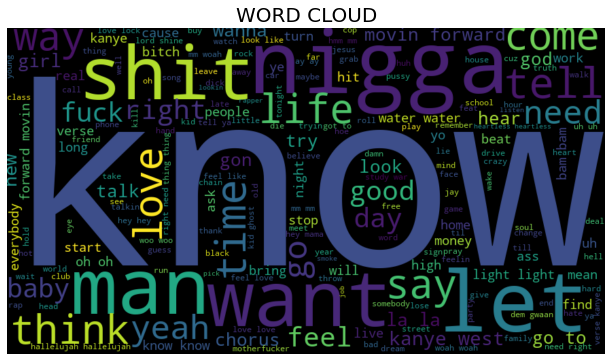

In [205]:
def plot_wordcloud_from_string(text):
    wordcloud = WordCloud(width=880, height=480, max_font_size = 1120,margin=0,background_color="black").generate(text)
    plt.figure(figsize=(20, 6))
    plt.imshow(wordcloud, interpolation='bilinear',)
    plt.axis("off")
    plt.title('WORD CLOUD', fontsize = 20)
    plt.margins(x=0, y=0)
    plt.show()
    
text_from_full_lyrics = " ".join(full_lyrics)
plot_wordcloud_from_string(text_from_full_lyrics)

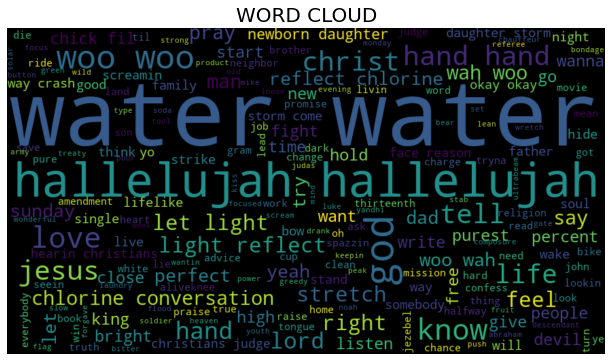

In [244]:
text_from_jik_lyrics = " ".join(jik_lyrics)
plot_wordcloud_from_string(text_from_jik_lyrics)

### 4) Escribir un informe

Este informe tiene que describir qué datos que obtuvieron, el volumen de estos (# de canciones del artista, # de canciones de la competencia, etc), una explicación de cómo estos se relacionan con la pregunta planteada, cómo ayudan a responderla y los resultados que obtuvieron. Usar la celda de abajo con formato markdown.




# Informe

## Problemas Encontrados

Las letras traen (kanye west) y nombres de raperos adentro delas letras por cómo se estucturan las letras de rap en genral

problema de dialectos y aave que dificulta contabilizar ocurrencias/distribuciones